<a href="https://colab.research.google.com/github/kordi1372/practice-git-skillz/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/agroimpacts/adleo/assignments/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Multi-layer perceptrons

## Instructions

Please follow the [instructions](assignments-setup.qmd) for setting up, completing, and submitting your assignments .

## Assignment Overview

After completing this assignment you will learn:

- Mechanics of MLP and modern DNNs, their building blocks and how to implement our model using ```torch.nn``` package.
- How to develop an image classification pipeline using PyTorch. The process is broken down into the steps below:

How to follow the Steps to approach a supervised ML/DL problem:

1. Define the problem to be solved (e.g. task specification)
2. Collect (labeled) data, and prepare it for analysis including data type specific pre-processing plus data splits, chipping, normalization and augmentation.
3. Choose an algorithm class (Architecture, training strategy and cost function)
4. Choose an optimization and learning rate policy
5. Choose metrics to evaluate the model performance
6. Apply regularization techniques if needed (usually an iterative process)


## Theoretical questions

### Q1

In an MLP for image classification with a single hidden layer (FC) with 1000 nodes and 10 output categories. What would be the total number of trainable parameters in case the input is:


#### A 100x100 greyscale image?

First layer learnable parameters: <!-- HTML input field -->
<input type="text" name="inputName" placeholder="Type here...">

Second layer learnable parameters: <!-- HTML input field -->
<input type="text" name="inputName" placeholder=" ">

#### A 100x100 multispectral image with 7 bands?

First layer weight and bias shapes that transform the input to the hidden features: <!-- HTML input field -->
<input type="text" name="inputName" placeholder="Type here...">

Second layer weight and bias shapes that map from the hidden features to output classes: <!-- HTML input field -->
<input type="text" name="inputName" placeholder="Type here...">


### Q2
Why do we need non-linear activation functions in DNNs?

<!-- HTML textarea -->
<textarea name="inputName" rows="4" cols="50" placeholder="Type here...">
</textarea>

---

### Q3
Why is ReLU iprefered in modern architectures over sigmoid activation functions? Please use the graph of these functions and their derivitives in your reasoning.

<!-- HTML textarea -->
<textarea name="inputName" rows="4" cols="50" placeholder="Type here...">
</textarea>

---

### **Q4.**
Why is it not common to use shuffling for validation and test datasets? Why is it important to apply shuffling during training?

**Hint:**
Look at how the ```train()``` and ```evaluation``` functions are defined in step 4. Do we do optimization in both phases? Also think about the meaning of using the SGD algorithm with mini-batch training, when we know that our loss surface in non-convex.

<!-- HTML textarea -->
<textarea name="inputName" rows="4" cols="50" placeholder="Type here...">
</textarea>


---

## Coding Assignment

Follow the instructions below to complete your coding assignment.

Run the code below unchanged, unless otherwise indicated.

### Static code 1

Run unchanged

In [12]:
# @title Mount drive and run imports
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# @title Importing Necessary Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [7]:
# @title Model save path

# Modify 'save_dir' to the path to your already downloaded MNIST dataset (from the main notebook).
save_dir = "/content/gdrive/MyDrive/adleo/data/assn1/"

### Static code 2
#### Transforms and loads (Steps 1.2-1.5)

In [13]:
# @title Necessary transforms - run unchanged
mnist_mean = 0.13066048920154572
mnist_std = 0.30810779333114624

train_transforms = transforms.Compose(
    [transforms.RandomRotation(5, fill=(0,)),
     transforms.RandomCrop(28, padding=2),
     transforms.ToTensor(),
     transforms.Normalize(mean=[mnist_mean], std=[mnist_std])]
     )

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[mnist_mean], std=[mnist_std])]
     )

In [14]:
# @title Load and split
train_data = datasets.MNIST(root=save_dir,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=save_dir,
                           train=False,
                           download=True,
                           transform=test_transforms)

train_ratio = 0.9

n_train_examples = int(len(train_data) * train_ratio)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,[n_train_examples,
                                                       n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [10]:
# @title Make iterable
# Don't change this cell
train_bsize=50
train_loader = data.DataLoader(train_data,
                               shuffle=True,
                               batch_size=train_bsize)

valid_loader = data.DataLoader(valid_data,
                               shuffle=False,
                               batch_size=train_bsize)

test_loader = data.DataLoader(test_data,
                              shuffle=False,
                              batch_size=train_bsize)

In [11]:
# @title Metrics and some other necessary functions
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = Variable(x).to(device)
        y = Variable(y).to(device)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    # Disable automatic differentiation as we don't do optimization on eval.
    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = Variable(x).to(device)
            y = Variable(y).to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


## Task 1: Adjust the model

Add the following five modifications to the model architecture:

1.  Use [leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#leakyrelu) as activation function.
2.  Regularization is VERY important in practice and it is shown that [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#dropout) works very well with DNNs. Please add it.
3.  Batch normalization is also act as a regulizer and usually results in a faster and better convergence to the point that nowadays its a common compenent of all modern neural networks.

    * **Hint 1:** You need to think where is the best place to add the BN layer before or after the non-linearity? Also, do you need to use [1D](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#batchnorm1d), [2D](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#batchnorm2d) or [3D](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm3d.html#batchnorm3d) implementation of BN based on that decision decide on the single required argument of the layer.

    * **Hint 2:** If you are using a BN layer you can set the bias for your ```nn.Linear()``` layer to ```False``` because the BN layer has a bias term included in it.

4. Its also good to have the option of using a $L_2$ regularization aka. [weight decay](https://d2l.ai/chapter_linear-regression/weight-decay.html) term. Please add it to your pipeline. Usually we choose a small term (e.g. ${1}^{-6}$).

  * **Hint:** In Pytorch, weight decay is implemented as part of the optimizer. For instance look at the arguments for [```torch.optim.SGD```](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#sgd).


5. There are two best coding rules that our code for ```MLP()``` violates. First several of the arguments to input layers are hard-coded (second argument to input layer, inputs and outputs, or nodes, to the hidden layer, and input to the output layer). Therefore, **your fifth required modification** is to revise the model so that it takes additional arguments that passes the information into the different layers, replacing the hard-coded values.

6. ***Optional but recommended:*** The model also fixes the number of hidden layers. What happens if you want to go deeper, and want more than one? This provides you with an optional modification you can make for extra credit, which is to design a model that can accept a flexible number of hidden layers and their feature sizes from the user.

  - **Hint:** ```hidden_dims``` should accept a list of integers where the length of the list decides on the number of hidden layers and each integer element represent the number of units in the layer. Your model should therefore have the exact same arguments as shown in the example below:

    ```
    model = MLP(in_dim, hidden_dims, out_dim, drop_rate)
    ```

In [75]:
# @title Modify your MLP as required
# Modify this cell
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, drop_rate, weight_decay=1e-6):
        super(MLP, self).__init__()

        layers = []
        self.hidden_dims = [in_dim] + hidden_dims + [out_dim]

        for i in range(len(self.hidden_dims) - 1):
            layers.append(nn.Linear(self.hidden_dims[i], self.hidden_dims[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(self.hidden_dims[i + 1]))
            layers.append(nn.LeakyReLU(0.1))
            layers.append(nn.Dropout(p=drop_rate))

        self.mlp_block = nn.Sequential(*layers)
        self.output_fc = nn.Linear(self.hidden_dims[-1], out_dim)

        self.weight_decay = weight_decay

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        y_pred = self.mlp_block(x)
        y_pred = self.output_fc(y_pred)

        return y_pred

If you are struggling to get it working, here is a commented out version of the example model that you can run and adapt.  You might want to use some of the other 3 examples that we suggested for structuring the model class

In [76]:
# @title Examples
# class MLP(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(MLP, self).__init__()

#         self.input_fc = nn.Linear(input_dim, 250)
#         self.hidden_fc = nn.Linear(250, 100)
#         self.output_fc = nn.Linear(100, output_dim)

#     def forward(self, x):

#         # x is a batch of images with the shape: [batch size, height, width]
#         batch_size = x.shape[0]

#         # First, we have to convert the 2D tensor (H and W) in
#         # an Mnist image, into a 1D tensor so that it can be fed into the first
#         # Linear layer, and we do that using the view().
#         x = x.view(batch_size, -1)

#         # x is now have the shape: [batch size, (height * width)]

#         # we pass input through each layer and the activation function in order, finally
#         # returning the output to give us our prediction for that image.
#         h_1 = F.relu(self.input_fc(x))

#         # h_1 = [batch size, 250]
#         h_2 = F.relu(self.hidden_fc(h_1))

#         # h_2 = [batch size, 100]
#         y_pred = self.output_fc(h_2)

#         # y_pred = [batch size, output dim]

#         return y_pred

In [87]:
# @title Define the parameters needed to run the model
# Define the parameters needed to run the model
in_dim = 28 * 28  # Input dimension (flattened image size for MNIST)
hidden_dims = [1000]  # List of hidden layer dimensions
out_dim = 10  # Output dimension (number of classes for MNIST)
drop_rate = 0.5  # Dropout rate
weight_decay = 1e-6  # L2 regularization term

# Hyperparameters
initial_lr = 0.001  # Initial learning rate
num_epochs = 10  # Number of training epochs
train_bsize = 54  # Training batch size


## Task 2: Show your work

Having updated the model with these modifications, your job is to show that the model works.  Re-run Steps 4-6 in the practical to train the model, show its loss curves, evaluates its performance, and save its output.

In [88]:
# @title Run and print the model
# Don't change this cell
#model = MLP(in_dim, hidden_dims, out_dim, drop_rate)
#model = MLP(in_dim, out_dim)
#print(model)

model = MLP(in_dim, hidden_dims, out_dim, drop_rate, weight_decay)
print(model)

MLP(
  (mlp_block): Sequential(
    (0): Linear(in_features=784, out_features=1000, bias=False)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_features=10, bias=False)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): Dropout(p=0.5, inplace=False)
  )
  (output_fc): Linear(in_features=10, out_features=10, bias=True)
)


In [89]:
# @title Show the number of parameters in the model
# Don't change this cell
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 796,130 trainable parameters


In [90]:
# @title Optimizer, loss criterion, and GPU/CPU switch
# @title Optimizer, loss criterion, and GPU/CPU switch
optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [91]:
# @title Train the model
best_val_loss = float('inf')
train_loss_per_epoch = []
val_loss_per_epoch = []
epoch_counter = []

for epoch in trange(num_epochs):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, valid_loader, criterion, device)

    # simple implementation of early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_mlp_tutorial.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

    epoch_counter.append(epoch)
    train_loss_per_epoch.append(train_loss)
    val_loss_per_epoch.append(val_loss)


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 44s
	Train Loss: 1.431 | Train Acc: 50.84%
	 Val. Loss: 0.525 |  Val. Acc: 92.57%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 44s
	Train Loss: 1.088 | Train Acc: 61.95%
	 Val. Loss: 0.330 |  Val. Acc: 95.22%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 43s
	Train Loss: 0.968 | Train Acc: 67.11%
	 Val. Loss: 0.278 |  Val. Acc: 94.93%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 43s
	Train Loss: 0.887 | Train Acc: 70.34%
	 Val. Loss: 0.237 |  Val. Acc: 95.45%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 44s
	Train Loss: 0.840 | Train Acc: 71.94%
	 Val. Loss: 0.209 |  Val. Acc: 95.73%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 44s
	Train Loss: 0.802 | Train Acc: 73.06%
	 Val. Loss: 0.205 |  Val. Acc: 95.92%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 43s
	Train Loss: 0.774 | Train Acc: 73.82%
	 Val. Loss: 0.185 |  Val. Acc: 95.77%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 43s
	Train Loss: 0.746 | Train Acc: 74.86%
	 Val. Loss: 0.178 |  Val. Acc: 95.87%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 42s
	Train Loss: 0.733 | Train Acc: 75.32%
	 Val. Loss: 0.173 |  Val. Acc: 96.20%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 44s
	Train Loss: 0.709 | Train Acc: 76.13%
	 Val. Loss: 0.158 |  Val. Acc: 96.25%


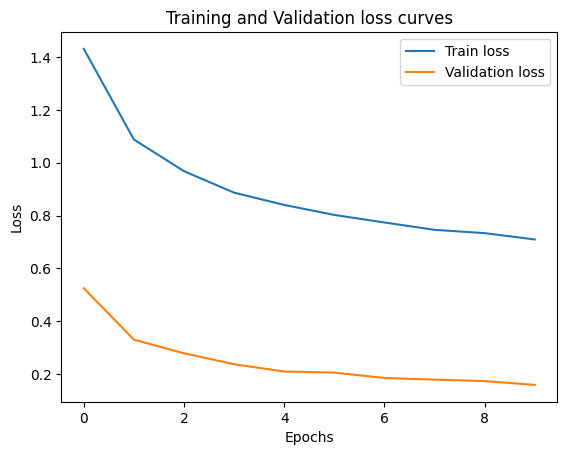

In [92]:
# @title Plot the results
plt.plot(epoch_counter, train_loss_per_epoch, label="Train loss")
plt.plot(epoch_counter, val_loss_per_epoch, label="Validation loss")
plt.title("Training and Validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Evaluate the performance

In [93]:
# @title Evaluate the performance
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Test Loss: 0.147 | Test Acc: 96.60%


Show the matrix

In [94]:
# @title Show the matrix
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [95]:
images, labels, probs = get_predictions(model, test_loader, device)

# We take the predicted labels using the index of the highest predicted
# probability.
pred_labels = torch.argmax(probs, 1)

In [96]:
images, labels, probs = get_predictions(model, test_loader, device)

# We take the predicted labels using the index of the highest predicted
# probability.
pred_labels = torch.argmax(probs, 1)

In [97]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

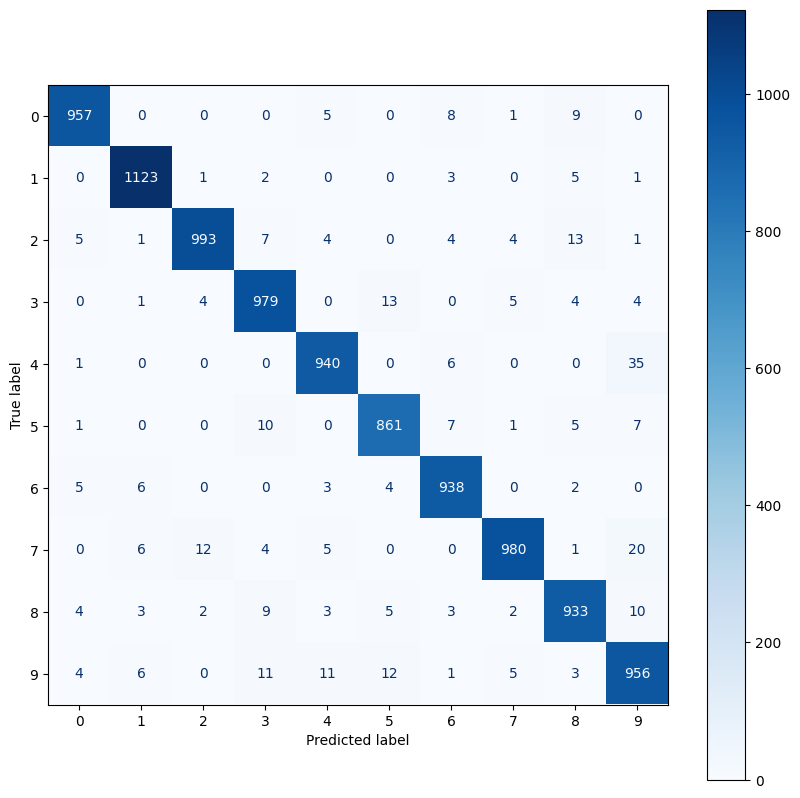

In [98]:
plot_confusion_matrix(labels, pred_labels)

## Optional Task 3

Use the model above and the parameters for batch size, learning rate, and dropout to evaluate model performance. Repeat using the code above from Task 2: Show your work. Provide the outputs (loss curves, performance metrics), from the best and worst results in the cells below.

**Practical tip:**
First tune the number of layers and number of computational units in each layer.
Check the models behavior and then tune the regularization parameter.

### Best result

In [142]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, drop_rate, weight_decay=1e-6):
        super(MLP, self).__init__()

        layers = []
        self.hidden_dims = [in_dim] + hidden_dims + [out_dim]

        for i in range(len(self.hidden_dims) - 1):
            layers.append(nn.Linear(self.hidden_dims[i], self.hidden_dims[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(self.hidden_dims[i + 1]))
            layers.append(nn.LeakyReLU(0.1))
            layers.append(nn.Dropout(p=drop_rate))

        self.mlp_block = nn.Sequential(*layers)
        self.output_fc = nn.Linear(self.hidden_dims[-1], out_dim)

        self.weight_decay = weight_decay

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        y_pred = self.mlp_block(x)
        y_pred = self.output_fc(y_pred)

        return y_pred

In [149]:
in_dim = 28 * 28
hidden_dims = [2000, 2500]  # Adjust the sizes of hidden layers
out_dim = 10
drop_rate = 0.5
weight_decay = 1e-6

# Hyperparameters
initial_lr = 0.001
num_epochs = 10
train_bsize = 54

In [150]:
model = MLP(in_dim, hidden_dims, out_dim, drop_rate, weight_decay)
print(model)

MLP(
  (mlp_block): Sequential(
    (0): Linear(in_features=784, out_features=2000, bias=False)
    (1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2000, out_features=2500, bias=False)
    (5): BatchNorm1d(2500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=2500, out_features=10, bias=False)
    (9): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): Dropout(p=0.5, inplace=False)
  )
  (output_fc): Linear(in_features=10, out_features=10, bias=True)
)


In [151]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,602,130 trainable parameters


In [152]:
optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# @title Train the model
best_val_loss = float('inf')
train_loss_per_epoch = []
val_loss_per_epoch = []
epoch_counter = []

for epoch in trange(num_epochs):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, valid_loader, criterion, device)

    # simple implementation of early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_mlp_tutorial.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

    epoch_counter.append(epoch)
    train_loss_per_epoch.append(train_loss)
    val_loss_per_epoch.append(val_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 3m 1s
	Train Loss: 1.362 | Train Acc: 54.45%
	 Val. Loss: 0.404 |  Val. Acc: 93.38%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 3m 0s
	Train Loss: 0.961 | Train Acc: 67.42%
	 Val. Loss: 0.262 |  Val. Acc: 95.13%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 3m 3s
	Train Loss: 0.829 | Train Acc: 71.90%
	 Val. Loss: 0.204 |  Val. Acc: 95.78%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 2m 56s
	Train Loss: 0.740 | Train Acc: 75.18%
	 Val. Loss: 0.171 |  Val. Acc: 96.40%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 2m 55s
	Train Loss: 0.695 | Train Acc: 76.91%
	 Val. Loss: 0.155 |  Val. Acc: 96.67%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 2m 56s
	Train Loss: 0.652 | Train Acc: 78.59%
	 Val. Loss: 0.144 |  Val. Acc: 96.87%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 3m 2s
	Train Loss: 0.617 | Train Acc: 79.73%
	 Val. Loss: 0.116 |  Val. Acc: 97.35%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 3m 1s
	Train Loss: 0.590 | Train Acc: 80.80%
	 Val. Loss: 0.119 |  Val. Acc: 97.23%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 3m 1s
	Train Loss: 0.568 | Train Acc: 81.34%
	 Val. Loss: 0.120 |  Val. Acc: 97.18%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

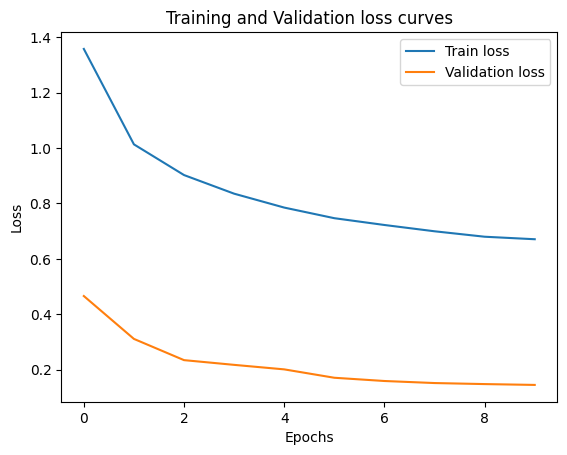

In [148]:
# @title Plot the results
plt.plot(epoch_counter, train_loss_per_epoch, label="Train loss")
plt.plot(epoch_counter, val_loss_per_epoch, label="Validation loss")
plt.title("Training and Validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
# @title Evaluate the performance
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [ ]:
# @title Show the matrix
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_loader, device)

# We take the predicted labels using the index of the highest predicted
# probability.
pred_labels = torch.argmax(probs, 1)

In [ ]:
images, labels, probs = get_predictions(model, test_loader, device)

# We take the predicted labels using the index of the highest predicted
# probability.
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

In [ ]:
plot_confusion_matrix(labels, pred_labels)

### Worst result